In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from datetime import datetime, timedelta

import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score 

import lightgbm as lgb
from optuna.integration import lightgbm as opt_lgb

In [35]:
dtype_list = {
    'Term':'int64',
    'NoEmp':'int64', 
    'NewExist':'object', 
    'CreateJob':'int64', 
    'RetainedJob':'int64',
    'FranchiseCode':'object', 
    'RevLineCr':'object', 
    'LowDoc':'object', 
    'DisbursementDate':'object',
    'MIS_Status':'int32', 
    'Sector':'object', 
    'ApprovalDate':'object', 
    'ApprovalFY':'object', 
    'City':'object', 
    'State':'object',
    'BankState':'object',
    'DisbursementGross':'object',
    'GrAppv':'object',
    'SBA_Appv':'object',
    'UrbanRural':'object'
}

In [36]:
train_df = pd.read_csv("train.csv", index_col=0, dtype=dtype_list)

In [37]:
train_df.select_dtypes(include="number").shape[1]

5

In [38]:
# アセスメントするための関数
def data_assessment(df):
    print(f"data_shape : {df.shape}")
    
    assessment_df = pd.DataFrame({"データ型" : df.dtypes,
                                  "欠損値" : df.isnull().sum(),
                                  "ユニーク数" : df.nunique()})
    
    # すべてが文字型の場合
    if df.select_dtypes(include="number").shape[1] == 0:
        # 文字型：count, top, feq, min
        assessment_str_df = df.describe().T.drop("unique", axis=1).rename(columns={"top":"max"})
        assessment_str_df["min"] = df.min()
        assessment_df = pd.merge(assessment_df, assessment_str_df, how="inner", left_index=True, right_index=True)
    
    # すべてが数値型型の場合
    elif df.select_dtypes(include=["object", "category"]).shape[1] == 0:
        # 数値型：count, mean, std, min, max
        assessment_num_df = df.select_dtypes(include="number").describe().T[["count", "mean", "std", "min", "max"]]
        assessment_df = pd.merge(assessment_df, assessment_num_df, how="inner", left_index=True, right_index=True)
    
    else:
        # 文字型：count, top, feq, min
        assessment_str_df = df.select_dtypes(include=["object", "category"]).describe().T.drop("unique", axis=1).rename(columns={"top":"max"})
        assessment_str_df["min"] = df.select_dtypes(include="object").min()
        # 数値型：count, mean, std, min, max
        assessment_num_df = df.select_dtypes(include="number").describe().T[["count", "mean", "std", "min", "max"]]
        
        assessment_df = pd.merge(assessment_df, pd.concat([assessment_str_df, assessment_num_df]), \
                             how="inner", left_index=True, right_index=True)
    
    return assessment_df

In [39]:
list(train_df.select_dtypes(include="object").columns)

['NewExist',
 'FranchiseCode',
 'RevLineCr',
 'LowDoc',
 'DisbursementDate',
 'Sector',
 'ApprovalDate',
 'ApprovalFY',
 'City',
 'State',
 'BankState',
 'DisbursementGross',
 'GrAppv',
 'SBA_Appv',
 'UrbanRural']

In [40]:
exec(f"display(data_assessment(train_df))")
exec(f"display(train_df.head(3))")

data_shape : (42307, 20)


C:\Users\takum\AppData\Local\Temp\ipykernel_9680\3435926937.py:25: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  assessment_str_df["min"] = df.select_dtypes(include="object").min()


,データ型,欠損値,ユニーク数,count,max,freq,min,mean,std
Term,int64,0,228,42307.0,360.0,NaN,0.0,108.601673,84.569847
NoEmp,int64,0,196,42307.0,202.0,NaN,0.0,9.704304,17.488022
NewExist,object,0,2,42307,1.0,33405,1.0,NaN,NaN
CreateJob,int64,0,49,42307.0,70.0,NaN,0.0,2.183728,5.093980
RetainedJob,int64,0,83,42307.0,140.0,NaN,0.0,3.478148,8.113648
FranchiseCode,object,0,271,42307,0,26392,0,NaN,NaN
RevLineCr,object,1079,4,41228,N,27618,NaN,NaN,NaN
LowDoc,object,531,6,41776,N,34313,NaN,NaN,NaN
DisbursementDate,object,150,916,42157,30-Nov-03,1634,NaN,NaN,NaN
MIS_Status,int32,0,2,42307.0,1.0,NaN,0.0,0.892689,0.309512


,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural
0,163,21,1.0,0,0,1,N,N,31-Jan-98,1,0,22-Sep-06,2006,PHOENIX,AZ,SD,"$80,000.00","$80,000.00","$68,000.00",0
1,84,6,1.0,4,0,0,0,N,31-Oct-93,1,62,30-Jun-92,1992,MCALESTER,OK,OK,"$287,000.00","$287,000.00","$229,600.00",0
2,242,45,1.0,4,90,0,N,N,31-Aug-01,1,42,18-Apr-01,2001,HAWTHORNE,NJ,NJ,"$31,983.00","$30,000.00","$15,000.00",1


In [41]:
test_df = pd.read_csv("test.csv", index_col=0, dtype=dtype_list)

In [42]:
exec(f"display(data_assessment(test_df))")
exec(f"display(test_df.head(3))")

data_shape : (42308, 19)


C:\Users\takum\AppData\Local\Temp\ipykernel_9680\3435926937.py:25: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  assessment_str_df["min"] = df.select_dtypes(include="object").min()


,データ型,欠損値,ユニーク数,count,max,freq,min,mean,std
Term,int64,0,229,42308.0,360.0,NaN,0.0,108.515222,84.894703
NoEmp,int64,0,190,42308.0,208.0,NaN,0.0,9.694715,17.242651
NewExist,object,0,2,42308,1.0,33472,1.0,NaN,NaN
CreateJob,int64,0,49,42308.0,86.0,NaN,0.0,2.186560,5.131680
RetainedJob,int64,0,85,42308.0,175.0,NaN,0.0,3.499645,8.134499
FranchiseCode,object,0,271,42308,0,26458,0,NaN,NaN
RevLineCr,object,1041,4,41267,N,27829,NaN,NaN,NaN
LowDoc,object,520,6,41788,N,34360,NaN,NaN,NaN
DisbursementDate,object,160,915,42148,30-Nov-03,1627,NaN,NaN,NaN
Sector,object,0,24,42308,0,9821,0,NaN,NaN


,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural
42307,5,2,1.0,1,0,0,T,N,31-Jul-04,23,6-Aug-07,2007,SUNNYVALE,CA,CA,"$25,000.00","$25,000.00","$21,250.00",1
42308,235,13,1.0,9,14,77725,Y,N,11-Jan-95,44,8-Mar-04,2004,PITTSBURGH,PA,PA,"$15,000.00","$15,000.00","$7,500.00",0
42309,31,5,2.0,0,0,0,N,NaN,NaN,56,27-Feb-07,2007,LITTLE ROCK,AR,AR,"$28,000.00","$28,000.00","$23,800.00",1


## EDA

1    37767
0     4540
Name: MIS_Status, dtype: int64


<Axes: xlabel='MIS_Status', ylabel='count'>

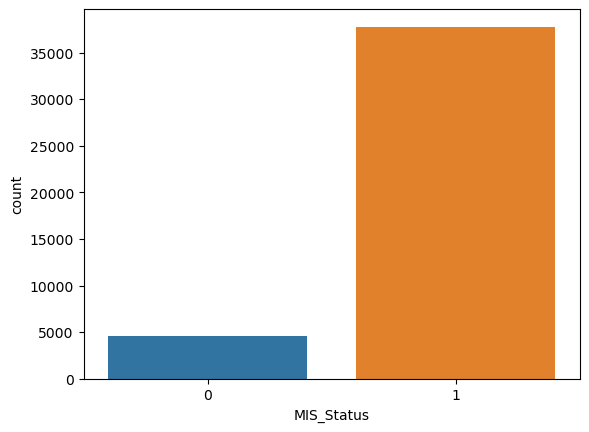

In [43]:
# カウントプロットの描画
print(train_df["MIS_Status"].value_counts())
sns.countplot(x='MIS_Status', data=train_df)

## LGBM

### 特徴量加工

In [88]:
use_x_col_list = [
    'Term', 
    'NoEmp', 
    # 'NewExist', 
    'CreateJob', 
    'RetainedJob',
    # 'FranchiseCode', 
    'RevLineCr', 
    'LowDoc', 
    'DisbursementDate',
    'MIS_Status', 
    'Sector', 
    'ApprovalDate', 
    'ApprovalFY', 
    'City', 
    'State',
    'BankState',
    'DisbursementGross',
    'GrAppv',
    'SBA_Appv',
    'UrbanRural', 
    'Approval_month',
    'Disbursement_year', 
    'Disbursement_month'
]

In [89]:
# ラベルエンコーディング
def label_encording(data_col):
    le = LabelEncoder()
    le = le.fit(data_col)
    data_col = le.transform(data_col)
    return data_col

In [90]:
# 日付を文字型に直す関数
def convert_to_datetime(date_string):
    if date_string == "NULL":
        date_cur_obj = "NULL"
    else:
        # 日付文字列のフォーマットに合わせてパース
        date_object = datetime.strptime(date_string, "%d-%b-%y")
        # 年月日の順に並べ替え
        date_cur_obj = datetime.strftime(date_object, "%Y-%m-%d")

    return date_cur_obj

In [91]:
# 融資と承認どちらが早いか
def disbursement_approval_dif(disbursement_day, approval_day):
    if disbursement_day == "NULL" or approval_day == "NULL":
        dif = "NULL"
    else:
        disbursement_day = datetime.strptime(disbursement_day, "%d-%b-%y")
        approval_day = datetime.strptime(approval_day, "%d-%b-%y")
        dif = str(int(disbursement_day > approval_day))
    return dif

In [92]:
# Sectorの前処理関数
def sector_prepro(sector):
    if sector in ["31", "32", "33"]:
        re_sector = "31"
    elif sector in ["44", "45"]:
        re_sector = "44"
    elif sector in ["48", "49"]:
        re_sector = "48"
    else:
        re_sector = sector
    return re_sector

In [113]:
# カテゴリ変数への変化と欠損値処理
def preprocess(df):
    df = df.drop([item for item in train_df.columns.values if item not in use_x_col_list], axis=1)
    
    # ドルマーク付きの金額表示を数値変換
    df["DisbursementGross"] = df["DisbursementGross"].apply(lambda x: x[1:][:-4].replace(',', '')).astype("int64")
    df["GrAppv"] = df["GrAppv"].apply(lambda x: x[1:][:-4].replace(',', '')).astype("int64")
    df["SBA_Appv"] = df["SBA_Appv"].apply(lambda x: x[1:][:-4].replace(',', '')).astype("int64")
    
    # 欠損値処理
    for col_name in df:
        if df[col_name].dtypes == object: # 欠損値に関してはNULLを代入する
            df[col_name] = df[col_name].fillna("NULL") 
        elif df[col_name].dtypes == ( "int64"  or  "float64") : # 欠損値に関しては-999999を代入する
            df[col_name] = df[col_name].fillna(-99999)
    
    # 日付から年と月を抜粋
    df["Approval_month"] = df["ApprovalDate"].apply(lambda x : convert_to_datetime(x)[5:7])
    # df["Approval_day"] = df["ApprovalDate"].apply(lambda x : convert_to_datetime(x)[8:])
    
    df["Disbursement_year"] = df["DisbursementDate"].apply(lambda x : convert_to_datetime(x)[:4])
    df["Disbursement_month"] = df["DisbursementDate"].apply(lambda x : convert_to_datetime(x)[5:7])
    # df["Disbursement_day"] = df["DisbursementDate"].apply(lambda x : convert_to_datetime(x)[8:])
    
    # Sectorの前処理
    df["Sector"] = df["Sector"].apply(sector_prepro)
    
    # # 融資と支払日
    # df["Dif_disbursement_approval"] = df.apply(lambda row: disbursement_approval_dif(row["ApprovalDate"], row["DisbursementDate"]), axis=1)
    
    # 市内の従業員数の平均
    city_df = df[["City","NoEmp", "Term"]].groupby("City", as_index=False).agg(["mean", "std"])
    city_df.columns = [f"{col[0]}_{col[1]}" for col in city_df.columns]
    city_df = city_df.rename(columns={"City_":"City"})
    
    df = pd.merge(df, city_df, how="left", on="City")
    
    # 市内の従業員数と比較した割合
    df["City_Ave_NoEmp_Ratio"] = df["NoEmp"] / df["NoEmp_mean"]
    # 市内の融資月と比較した割合
    df["City_Ave_Term_Ratio"] = df["Term"] / df["Term_mean"]
    
    
    # 都市部・田舎の従業員数の平均
    urban_df = df[["UrbanRural","NoEmp", "Term"]].groupby("UrbanRural", as_index=False).agg(["mean", "std"])
    urban_df.columns = [f"Urban_{col[0]}_{col[1]}" for col in urban_df.columns]
    urban_df = urban_df.rename(columns={"Urban_UrbanRural_":"UrbanRural"})
    
    df = pd.merge(df, urban_df, how="left", on="UrbanRural")
    
    # 市内の従業員数と比較した割合
    df["Urban_Ave_NoEmp_Ratio"] = df["NoEmp"] / df["Urban_NoEmp_mean"]
    # 市内の融資月と比較した割合
    df["Urban_Ave_Term_Ratio"] = df["Term"] / df["Urban_Term_mean"]
    
    
    # Sectorの従業員数の平均
    sector_df = df[["Sector", "NoEmp", "Term"]].groupby("Sector", as_index=False).agg(["mean", "std"])
    sector_df.columns = [f"Sector_{col[0]}_{col[1]}" for col in sector_df.columns]
    sector_df = sector_df.rename(columns={"Sector_Sector_":"Sector"})
    
    df = pd.merge(df, sector_df, how="left", on="Sector")
    
    # セクター内の従業員数と比較した割合
    df["Sector_Ave_NoEmp_Ratio"] = df["NoEmp"] / df["Sector_NoEmp_mean"]
    # セクター内の融資月と比較した割合
    df["Sector_Ave_Term_Ratio"] = df["Term"] / df["Sector_Term_mean"]
    
    
    # 従業員数に対する融資を受けて創出される雇用の数の割合
    df["CreateJob_Ratio"] = df["CreateJob"] / df["NoEmp"]
    
    # 従業員数に対する融資を受けたことによる維持する雇用の数
    df["RetainedJob_Ratio"] = df["RetainedJob"] / df["NoEmp"]
    
    # 銀行によって承認されたローンのうち、支払われたローンの総額の割合
    df["Disbursement_Ratio"] = df["DisbursementGross"] / df["GrAppv"]
    
    # 銀行によって承認されたローンのうち、支払われたローンの総額の割合
    df["SBA_Ratio"] = df["SBA_Appv"] / df["GrAppv"]    
    
    # モデル作成には使わない変数を削除
    df = df.drop(['DisbursementDate', 'ApprovalDate', 'City', "Sector", "MIS_Status", "State"], axis=1)
    
    # ラベルエンコーディング
    category_list = []
    for col_name in df:
        if df[col_name].dtypes == object:
            df[col_name] = label_encording(df[col_name])
            df[col_name] = df[col_name].astype("category")
    
    return df

In [114]:
all_x = pd.concat([train_df, test_df])
prepro_all_x = preprocess(all_x)
prepro_train_y = label_encording(train_df["MIS_Status"].astype("str"))

# 前処理を行なったデータを，学習データとテストデータに再分割
prepro_train_x, prepro_test = prepro_all_x[:train_df.shape[0]], prepro_all_x[train_df.shape[0]:]

In [115]:
exec(f"display(data_assessment(prepro_train_x))")
exec(f"display(prepro_train_x.head(3))")

data_shape : (42307, 37)


,データ型,欠損値,ユニーク数,count,max,freq,min,mean,std
Term,int64,0,228,42307.0,3.600000e+02,NaN,0.000000,1.086017e+02,84.569847
NoEmp,int64,0,196,42307.0,2.020000e+02,NaN,0.000000,9.704304e+00,17.488022
CreateJob,int64,0,49,42307.0,7.000000e+01,NaN,0.000000,2.183728e+00,5.093980
RetainedJob,int64,0,83,42307.0,1.400000e+02,NaN,0.000000,3.478148e+00,8.113648
RevLineCr,category,0,5,42307.0,1.000000e+00,27618.0,NaN,NaN,NaN
LowDoc,category,0,7,42307.0,3.000000e+00,34313.0,NaN,NaN,NaN
ApprovalFY,category,0,38,42307.0,2.700000e+01,4708.0,NaN,NaN,NaN
BankState,category,0,52,42307.0,4.000000e+00,6476.0,NaN,NaN,NaN
DisbursementGross,int64,0,2694,42307.0,6.296554e+06,NaN,4000.000000,1.793574e+05,248723.172878
GrAppv,int64,0,1425,42307.0,3.500000e+06,NaN,2000.000000,1.739594e+05,247265.738197


,Term,NoEmp,CreateJob,RetainedJob,RevLineCr,LowDoc,ApprovalFY,BankState,DisbursementGross,GrAppv,...,Sector_NoEmp_mean,Sector_NoEmp_std,Sector_Term_mean,Sector_Term_std,Sector_Ave_NoEmp_Ratio,Sector_Ave_Term_Ratio,CreateJob_Ratio,RetainedJob_Ratio,Disbursement_Ratio,SBA_Ratio
0,163,21,0,0,1,3,29,43,80000,80000,...,11.476069,26.914909,114.104440,74.310003,1.829895,1.428516,0.000000,0.0,1.0000,0.85
1,84,6,4,0,0,3,15,37,287000,287000,...,8.966865,12.457005,110.574766,84.594197,0.669130,0.759667,0.666667,0.0,1.0000,0.80
2,242,45,4,90,1,3,24,31,31983,30000,...,10.388384,13.907888,114.423624,92.092597,4.331762,2.114948,0.088889,2.0,1.0661,0.50


In [96]:
# # ターゲットエンコーディング
# sector_target_df = pd.concat([train_x, train_y], axis=1)[["City", "MIS_Status"]].groupby("City", as_index=False).agg(["mean", "std"])
# sector_target_df.columns = [f"City_{col[0]}_{col[1]}" for col in sector_target_df.columns]
# sector_target_df = sector_target_df.reset_index()
# df = pd.merge(df, sector_target_df, how="left", on="City")

In [121]:
# optunaによる学習
def model_learning(x, y):
    
    train_x, val_x, train_y, val_y = train_test_split(x, y, random_state=33, test_size=0.25, shuffle=True)
    
    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_val = lgb.Dataset(val_x, val_y)
    
    params = {'objective': 'binary',
              'metric':'auc',
              'verbosity':-1}
    
    model = opt_lgb.train(params,
                          lgb_train,
                          num_boost_round=100,
                          valid_sets=[lgb_train, lgb_val],
                          # categorical_feature=category_list
                         )
    best_params = model.params
    
    return model, val_x, val_y, best_params

In [122]:
# 精度検証
def eval_accuracy_score(model, val_X, val_y, judge_pred):
    model_pred_proba = model.predict(val_X)
    model_pred = (model_pred_proba > judge_pred).astype(int)  # 予測確率をクラスに変換
    mean_f1 = np.mean([f1_score(val_y, model_pred, average=None)])
    print(f'accuracy_score: {accuracy_score(model_pred, val_y)}')
    print(f'mean_f1_score: {mean_f1}')

In [123]:
def model_train(x, y, judge_pred):
    model, val_x, val_y, best_params = model_learning(x, y)
    eval_accuracy_score(model, val_x, val_y, judge_pred)
    return model

In [124]:
def test_submission(x, y, judge_pred):
    model = model_train(x, y, judge_pred)
    test_pred_proba = model.predict(prepro_test)
    test_pred = (test_pred_proba > judge_pred).astype(int)
    return test_pred, model

In [125]:
test_pred, lgb_model = test_submission(prepro_train_x, prepro_train_y, judge_pred=0.795)

[I 2024-02-10 17:03:02,124] A new study created in memory with name: no-name-76abb43d-9449-424d-ae0b-cdc49e001800


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




feature_fraction, val_score: 0.778629:   0%|          | 0/7 [00:01<?, ?it/s]

feature_fraction, val_score: 0.778629:  14%|#4        | 1/7 [00:01<00:06,  1.01s/it][I 2024-02-10 17:03:03,153] Trial 0 finished with value: 0.778629255914073 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.778629255914073.


feature_fraction, val_score: 0.778629:  14%|#4        | 1/7 [00:01<00:06,  1.01s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




feature_fraction, val_score: 0.782285:  14%|#4        | 1/7 [00:01<00:06,  1.01s/it]

feature_fraction, val_score: 0.782285:  29%|##8       | 2/7 [00:01<00:04,  1.10it/s][I 2024-02-10 17:03:03,987] Trial 1 finished with value: 0.7822854212722111 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.7822854212722111.


feature_fraction, val_score: 0.782285:  29%|##8       | 2/7 [00:01<00:04,  1.10it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




feature_fraction, val_score: 0.782285:  29%|##8       | 2/7 [00:02<00:04,  1.10it/s]

feature_fraction, val_score: 0.782285:  43%|####2     | 3/7 [00:02<00:03,  1.25it/s][I 2024-02-10 17:03:04,677] Trial 2 finished with value: 0.7772902538937002 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.7822854212722111.


feature_fraction, val_score: 0.782285:  43%|####2     | 3/7 [00:02<00:03,  1.25it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




feature_fraction, val_score: 0.782285:  43%|####2     | 3/7 [00:03<00:03,  1.25it/s]

feature_fraction, val_score: 0.782285:  57%|#####7    | 4/7 [00:03<00:02,  1.27it/s][I 2024-02-10 17:03:05,435] Trial 3 finished with value: 0.7790674129751093 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.7822854212722111.


feature_fraction, val_score: 0.782285:  57%|#####7    | 4/7 [00:03<00:02,  1.27it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




feature_fraction, val_score: 0.782285:  57%|#####7    | 4/7 [00:03<00:02,  1.27it/s]

feature_fraction, val_score: 0.782285:  71%|#######1  | 5/7 [00:03<00:01,  1.32it/s][I 2024-02-10 17:03:06,138] Trial 4 finished with value: 0.7815957649441209 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.7822854212722111.


feature_fraction, val_score: 0.782285:  71%|#######1  | 5/7 [00:03<00:01,  1.32it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




feature_fraction, val_score: 0.782285:  71%|#######1  | 5/7 [00:04<00:01,  1.32it/s]

feature_fraction, val_score: 0.782285:  86%|########5 | 6/7 [00:04<00:00,  1.30it/s][I 2024-02-10 17:03:06,925] Trial 5 finished with value: 0.7769189864211808 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.7822854212722111.


feature_fraction, val_score: 0.782285:  86%|########5 | 6/7 [00:04<00:00,  1.30it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




feature_fraction, val_score: 0.782285:  86%|########5 | 6/7 [00:05<00:00,  1.30it/s]

feature_fraction, val_score: 0.782285: 100%|##########| 7/7 [00:05<00:00,  1.26it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.782285:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782285:   0%|          | 0/20 [00:01<?, ?it/s]

num_leaves, val_score: 0.782285:   5%|5         | 1/20 [00:01<00:22,  1.16s/it][I 2024-02-10 17:03:08,861] Trial 7 finished with value: 0.7760752559539181 and parameters: {'num_leaves': 128}. Best is trial 7 with value: 0.7760752559539181.


num_leaves, val_score: 0.782285:   5%|5         | 1/20 [00:01<00:22,  1.16s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782285:   5%|5         | 1/20 [00:02<00:22,  1.16s/it]

num_leaves, val_score: 0.782285:  10%|#         | 2/20 [00:02<00:27,  1.53s/it][I 2024-02-10 17:03:10,651] Trial 8 finished with value: 0.7700769774880459 and parameters: {'num_leaves': 256}. Best is trial 7 with value: 0.7760752559539181.


num_leaves, val_score: 0.782285:  10%|#         | 2/20 [00:02<00:27,  1.53s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782285:  10%|#         | 2/20 [00:04<00:27,  1.53s/it]

num_leaves, val_score: 0.782285:  15%|#5        | 3/20 [00:04<00:22,  1.34s/it][I 2024-02-10 17:03:11,772] Trial 9 finished with value: 0.7750658608759864 and parameters: {'num_leaves': 101}. Best is trial 7 with value: 0.7760752559539181.


num_leaves, val_score: 0.782285:  15%|#5        | 3/20 [00:04<00:22,  1.34s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  15%|#5        | 3/20 [00:04<00:22,  1.34s/it]

num_leaves, val_score: 0.782795:  20%|##        | 4/20 [00:04<00:17,  1.09s/it][I 2024-02-10 17:03:12,480] Trial 10 finished with value: 0.782795402018064 and parameters: {'num_leaves': 9}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  20%|##        | 4/20 [00:04<00:17,  1.09s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  20%|##        | 4/20 [00:05<00:17,  1.09s/it]

num_leaves, val_score: 0.782795:  25%|##5       | 5/20 [00:05<00:14,  1.06it/s][I 2024-02-10 17:03:13,147] Trial 11 finished with value: 0.7814635684017494 and parameters: {'num_leaves': 5}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  25%|##5       | 5/20 [00:05<00:14,  1.06it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  25%|##5       | 5/20 [00:06<00:14,  1.06it/s]

num_leaves, val_score: 0.782795:  30%|###       | 6/20 [00:06<00:13,  1.04it/s][I 2024-02-10 17:03:14,158] Trial 12 finished with value: 0.7783298586744485 and parameters: {'num_leaves': 32}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  30%|###       | 6/20 [00:06<00:13,  1.04it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  30%|###       | 6/20 [00:08<00:13,  1.04it/s]

num_leaves, val_score: 0.782795:  35%|###5      | 7/20 [00:08<00:17,  1.33s/it][I 2024-02-10 17:03:16,230] Trial 13 finished with value: 0.7674561344874526 and parameters: {'num_leaves': 223}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  35%|###5      | 7/20 [00:08<00:17,  1.33s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  35%|###5      | 7/20 [00:09<00:17,  1.33s/it]

num_leaves, val_score: 0.782795:  40%|####      | 8/20 [00:09<00:15,  1.25s/it][I 2024-02-10 17:03:17,346] Trial 14 finished with value: 0.7784631258226209 and parameters: {'num_leaves': 66}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  40%|####      | 8/20 [00:09<00:15,  1.25s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  40%|####      | 8/20 [00:11<00:15,  1.25s/it]

num_leaves, val_score: 0.782795:  45%|####5     | 9/20 [00:11<00:15,  1.44s/it][I 2024-02-10 17:03:19,178] Trial 15 finished with value: 0.7661403599581514 and parameters: {'num_leaves': 184}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  45%|####5     | 9/20 [00:11<00:15,  1.44s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  45%|####5     | 9/20 [00:13<00:15,  1.44s/it]

num_leaves, val_score: 0.782795:  50%|#####     | 10/20 [00:13<00:14,  1.47s/it][I 2024-02-10 17:03:20,746] Trial 16 finished with value: 0.7676652750032537 and parameters: {'num_leaves': 165}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  50%|#####     | 10/20 [00:13<00:14,  1.47s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  50%|#####     | 10/20 [00:13<00:14,  1.47s/it]

num_leaves, val_score: 0.782795:  55%|#####5    | 11/20 [00:13<00:11,  1.28s/it][I 2024-02-10 17:03:21,582] Trial 17 finished with value: 0.7780571800317682 and parameters: {'num_leaves': 71}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  55%|#####5    | 11/20 [00:13<00:11,  1.28s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  55%|#####5    | 11/20 [00:14<00:11,  1.28s/it]

num_leaves, val_score: 0.782795:  60%|######    | 12/20 [00:14<00:08,  1.05s/it][I 2024-02-10 17:03:22,098] Trial 18 finished with value: 0.7814635684017494 and parameters: {'num_leaves': 5}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  60%|######    | 12/20 [00:14<00:08,  1.05s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  60%|######    | 12/20 [00:15<00:08,  1.05s/it]

num_leaves, val_score: 0.782795:  65%|######5   | 13/20 [00:15<00:06,  1.04it/s][I 2024-02-10 17:03:22,865] Trial 19 finished with value: 0.7772232246609484 and parameters: {'num_leaves': 52}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  65%|######5   | 13/20 [00:15<00:06,  1.04it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  65%|######5   | 13/20 [00:16<00:06,  1.04it/s]

num_leaves, val_score: 0.782795:  70%|#######   | 14/20 [00:16<00:05,  1.05it/s][I 2024-02-10 17:03:23,779] Trial 20 finished with value: 0.7759048899873408 and parameters: {'num_leaves': 96}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  70%|#######   | 14/20 [00:16<00:05,  1.05it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  70%|#######   | 14/20 [00:17<00:05,  1.05it/s]

num_leaves, val_score: 0.782795:  75%|#######5  | 15/20 [00:17<00:05,  1.04s/it][I 2024-02-10 17:03:25,029] Trial 21 finished with value: 0.7670201186380181 and parameters: {'num_leaves': 161}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  75%|#######5  | 15/20 [00:17<00:05,  1.04s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  75%|#######5  | 15/20 [00:18<00:05,  1.04s/it]

num_leaves, val_score: 0.782795:  80%|########  | 16/20 [00:18<00:04,  1.07s/it][I 2024-02-10 17:03:26,163] Trial 22 finished with value: 0.7731973744649531 and parameters: {'num_leaves': 123}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  80%|########  | 16/20 [00:18<00:04,  1.07s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  80%|########  | 16/20 [00:19<00:04,  1.07s/it]

num_leaves, val_score: 0.782795:  85%|########5 | 17/20 [00:19<00:03,  1.15s/it][I 2024-02-10 17:03:27,505] Trial 23 finished with value: 0.7689836562249397 and parameters: {'num_leaves': 196}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  85%|########5 | 17/20 [00:19<00:03,  1.15s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  85%|########5 | 17/20 [00:20<00:03,  1.15s/it]

num_leaves, val_score: 0.782795:  90%|######### | 18/20 [00:20<00:02,  1.06s/it][I 2024-02-10 17:03:28,360] Trial 24 finished with value: 0.7794688901504453 and parameters: {'num_leaves': 38}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  90%|######### | 18/20 [00:20<00:02,  1.06s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  90%|######### | 18/20 [00:22<00:02,  1.06s/it]

num_leaves, val_score: 0.782795:  95%|#########5| 19/20 [00:22<00:01,  1.16s/it][I 2024-02-10 17:03:29,753] Trial 25 finished with value: 0.7730808180768903 and parameters: {'num_leaves': 94}. Best is trial 10 with value: 0.782795402018064.


num_leaves, val_score: 0.782795:  95%|#########5| 19/20 [00:22<00:01,  1.16s/it]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




num_leaves, val_score: 0.782795:  95%|#########5| 19/20 [00:23<00:01,  1.16s/it]

num_leaves, val_score: 0.782795: 100%|##########| 20/20 [00:23<00:00,  1.19s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.782795:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




bagging, val_score: 0.784279:   0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.784279:  10%|#         | 1/10 [00:00<00:07,  1.14it/s][I 2024-02-10 17:03:32,368] Trial 27 finished with value: 0.7842794013023408 and parameters: {'bagging_fraction': 0.8839514368583403, 'bagging_freq': 1}. Best is trial 27 with value: 0.7842794013023408.


bagging, val_score: 0.784279:  10%|#         | 1/10 [00:00<00:07,  1.14it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




bagging, val_score: 0.784448:  10%|#         | 1/10 [00:01<00:07,  1.14it/s]

bagging, val_score: 0.784448:  20%|##        | 2/10 [00:01<00:06,  1.18it/s][I 2024-02-10 17:03:33,202] Trial 28 finished with value: 0.7844480915380994 and parameters: {'bagging_fraction': 0.9073707609190054, 'bagging_freq': 1}. Best is trial 28 with value: 0.7844480915380994.


bagging, val_score: 0.784448:  20%|##        | 2/10 [00:01<00:06,  1.18it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




bagging, val_score: 0.784448:  20%|##        | 2/10 [00:02<00:06,  1.18it/s]

bagging, val_score: 0.784448:  30%|###       | 3/10 [00:02<00:05,  1.21it/s][I 2024-02-10 17:03:33,990] Trial 29 finished with value: 0.7830926580460867 and parameters: {'bagging_fraction': 0.9192055142081594, 'bagging_freq': 1}. Best is trial 28 with value: 0.7844480915380994.


bagging, val_score: 0.784448:  30%|###       | 3/10 [00:02<00:05,  1.21it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




bagging, val_score: 0.784448:  30%|###       | 3/10 [00:03<00:05,  1.21it/s]

bagging, val_score: 0.784448:  40%|####      | 4/10 [00:03<00:04,  1.22it/s][I 2024-02-10 17:03:34,806] Trial 30 finished with value: 0.7840922314794971 and parameters: {'bagging_fraction': 0.9209133531072098, 'bagging_freq': 1}. Best is trial 28 with value: 0.7844480915380994.


bagging, val_score: 0.784448:  40%|####      | 4/10 [00:03<00:04,  1.22it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




bagging, val_score: 0.784448:  40%|####      | 4/10 [00:04<00:04,  1.22it/s]

bagging, val_score: 0.784448:  50%|#####     | 5/10 [00:04<00:04,  1.19it/s][I 2024-02-10 17:03:35,699] Trial 31 finished with value: 0.7823456544855311 and parameters: {'bagging_fraction': 0.9150091740319289, 'bagging_freq': 1}. Best is trial 28 with value: 0.7844480915380994.


bagging, val_score: 0.784448:  50%|#####     | 5/10 [00:04<00:04,  1.19it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




bagging, val_score: 0.784448:  50%|#####     | 5/10 [00:04<00:04,  1.19it/s]

bagging, val_score: 0.784448:  60%|######    | 6/10 [00:04<00:03,  1.24it/s][I 2024-02-10 17:03:36,426] Trial 32 finished with value: 0.7828795609436301 and parameters: {'bagging_fraction': 0.9157001557692591, 'bagging_freq': 1}. Best is trial 28 with value: 0.7844480915380994.


bagging, val_score: 0.784448:  60%|######    | 6/10 [00:04<00:03,  1.24it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




bagging, val_score: 0.784448:  60%|######    | 6/10 [00:05<00:03,  1.24it/s]

bagging, val_score: 0.784448:  70%|#######   | 7/10 [00:05<00:02,  1.36it/s][I 2024-02-10 17:03:37,034] Trial 33 finished with value: 0.7813233655899103 and parameters: {'bagging_fraction': 0.9133937725862342, 'bagging_freq': 1}. Best is trial 28 with value: 0.7844480915380994.


bagging, val_score: 0.784448:  70%|#######   | 7/10 [00:05<00:02,  1.36it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




bagging, val_score: 0.784448:  70%|#######   | 7/10 [00:06<00:02,  1.36it/s]

bagging, val_score: 0.784448:  80%|########  | 8/10 [00:06<00:01,  1.43it/s][I 2024-02-10 17:03:37,629] Trial 34 finished with value: 0.7822549788290031 and parameters: {'bagging_fraction': 0.9155850932782155, 'bagging_freq': 1}. Best is trial 28 with value: 0.7844480915380994.


bagging, val_score: 0.784448:  80%|########  | 8/10 [00:06<00:01,  1.43it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




bagging, val_score: 0.784448:  80%|########  | 8/10 [00:06<00:01,  1.43it/s]

bagging, val_score: 0.784448:  90%|######### | 9/10 [00:06<00:00,  1.47it/s][I 2024-02-10 17:03:38,265] Trial 35 finished with value: 0.7826942995919968 and parameters: {'bagging_fraction': 0.7490626188763015, 'bagging_freq': 1}. Best is trial 28 with value: 0.7844480915380994.


bagging, val_score: 0.784448:  90%|######### | 9/10 [00:06<00:00,  1.47it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




bagging, val_score: 0.784448:  90%|######### | 9/10 [00:07<00:00,  1.47it/s]

bagging, val_score: 0.784448: 100%|##########| 10/10 [00:07<00:00,  1.34it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.784448:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




feature_fraction_stage2, val_score: 0.784448:   0%|          | 0/3 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.784448:  33%|###3      | 1/3 [00:00<00:01,  1.66it/s][I 2024-02-10 17:03:39,558] Trial 37 finished with value: 0.7824308840168981 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 0.7824308840168981.


feature_fraction_stage2, val_score: 0.784448:  33%|###3      | 1/3 [00:00<00:01,  1.66it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




feature_fraction_stage2, val_score: 0.784448:  33%|###3      | 1/3 [00:01<00:01,  1.66it/s]

feature_fraction_stage2, val_score: 0.784448:  67%|######6   | 2/3 [00:01<00:00,  1.58it/s][I 2024-02-10 17:03:40,215] Trial 38 finished with value: 0.7808453633738494 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 0.7824308840168981.


feature_fraction_stage2, val_score: 0.784448:  67%|######6   | 2/3 [00:01<00:00,  1.58it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




feature_fraction_stage2, val_score: 0.784448:  67%|######6   | 2/3 [00:01<00:00,  1.58it/s]

feature_fraction_stage2, val_score: 0.784448: 100%|##########| 3/3 [00:01<00:00,  1.61it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.784448:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784448:   0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.784448:   5%|5         | 1/20 [00:00<00:12,  1.49it/s][I 2024-02-10 17:03:41,498] Trial 40 finished with value: 0.7842688348885667 and parameters: {'lambda_l1': 1.0502111408255818e-07, 'lambda_l2': 0.7611833056446107}. Best is trial 40 with value: 0.7842688348885667.


regularization_factors, val_score: 0.784448:   5%|5         | 1/20 [00:00<00:12,  1.49it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784448:   5%|5         | 1/20 [00:01<00:12,  1.49it/s]

regularization_factors, val_score: 0.784448:  10%|#         | 2/20 [00:01<00:11,  1.52it/s][I 2024-02-10 17:03:42,148] Trial 41 finished with value: 0.7828262168458985 and parameters: {'lambda_l1': 2.2714618740842557e-08, 'lambda_l2': 2.2157852085382927}. Best is trial 40 with value: 0.7842688348885667.


regularization_factors, val_score: 0.784448:  10%|#         | 2/20 [00:01<00:11,  1.52it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784448:  10%|#         | 2/20 [00:01<00:11,  1.52it/s]

regularization_factors, val_score: 0.784448:  15%|#5        | 3/20 [00:01<00:11,  1.53it/s][I 2024-02-10 17:03:42,798] Trial 42 finished with value: 0.7823722799863186 and parameters: {'lambda_l1': 4.687465981298185e-06, 'lambda_l2': 0.024991496193016882}. Best is trial 40 with value: 0.7842688348885667.


regularization_factors, val_score: 0.784448:  15%|#5        | 3/20 [00:01<00:11,  1.53it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784448:  15%|#5        | 3/20 [00:02<00:11,  1.53it/s]

regularization_factors, val_score: 0.784448:  20%|##        | 4/20 [00:02<00:10,  1.53it/s][I 2024-02-10 17:03:43,447] Trial 43 finished with value: 0.7830888876517444 and parameters: {'lambda_l1': 3.2049585954317426, 'lambda_l2': 3.7090053299530316e-08}. Best is trial 40 with value: 0.7842688348885667.


regularization_factors, val_score: 0.784448:  20%|##        | 4/20 [00:02<00:10,  1.53it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784448:  20%|##        | 4/20 [00:03<00:10,  1.53it/s]

regularization_factors, val_score: 0.784448:  25%|##5       | 5/20 [00:03<00:09,  1.55it/s][I 2024-02-10 17:03:44,082] Trial 44 finished with value: 0.7844481846342559 and parameters: {'lambda_l1': 0.000592627142409043, 'lambda_l2': 6.341307589406814e-05}. Best is trial 44 with value: 0.7844481846342559.


regularization_factors, val_score: 0.784448:  25%|##5       | 5/20 [00:03<00:09,  1.55it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784448:  25%|##5       | 5/20 [00:04<00:09,  1.55it/s]

regularization_factors, val_score: 0.784448:  30%|###       | 6/20 [00:04<00:10,  1.39it/s][I 2024-02-10 17:03:44,951] Trial 45 finished with value: 0.7838488315780674 and parameters: {'lambda_l1': 0.008834939466892077, 'lambda_l2': 3.1956040430214715e-05}. Best is trial 44 with value: 0.7844481846342559.


regularization_factors, val_score: 0.784448:  30%|###       | 6/20 [00:04<00:10,  1.39it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784448:  30%|###       | 6/20 [00:04<00:10,  1.39it/s]

regularization_factors, val_score: 0.784448:  35%|###5      | 7/20 [00:04<00:09,  1.30it/s][I 2024-02-10 17:03:45,826] Trial 46 finished with value: 0.7844484639227257 and parameters: {'lambda_l1': 0.0001485879729550264, 'lambda_l2': 0.00015906388673257656}. Best is trial 46 with value: 0.7844484639227257.


regularization_factors, val_score: 0.784448:  35%|###5      | 7/20 [00:04<00:09,  1.30it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784448:  35%|###5      | 7/20 [00:05<00:09,  1.30it/s]

regularization_factors, val_score: 0.784448:  40%|####      | 8/20 [00:05<00:09,  1.24it/s][I 2024-02-10 17:03:46,712] Trial 47 finished with value: 0.7844483708265692 and parameters: {'lambda_l1': 0.0009986332158168324, 'lambda_l2': 5.341233772427249e-05}. Best is trial 46 with value: 0.7844484639227257.


regularization_factors, val_score: 0.784448:  40%|####      | 8/20 [00:05<00:09,  1.24it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784448:  40%|####      | 8/20 [00:06<00:09,  1.24it/s]

regularization_factors, val_score: 0.784448:  45%|####5     | 9/20 [00:06<00:09,  1.20it/s][I 2024-02-10 17:03:47,590] Trial 48 finished with value: 0.7844484639227257 and parameters: {'lambda_l1': 0.0009993057525192958, 'lambda_l2': 3.3132212455933875e-05}. Best is trial 46 with value: 0.7844484639227257.


regularization_factors, val_score: 0.784448:  45%|####5     | 9/20 [00:06<00:09,  1.20it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784448:  45%|####5     | 9/20 [00:07<00:09,  1.20it/s]

regularization_factors, val_score: 0.784448:  50%|#####     | 10/20 [00:07<00:08,  1.19it/s][I 2024-02-10 17:03:48,463] Trial 49 finished with value: 0.7844482777304125 and parameters: {'lambda_l1': 0.0006997377295840039, 'lambda_l2': 4.638936149615392e-05}. Best is trial 46 with value: 0.7844484639227257.


regularization_factors, val_score: 0.784448:  50%|#####     | 10/20 [00:07<00:08,  1.19it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784448:  50%|#####     | 10/20 [00:08<00:08,  1.19it/s]

regularization_factors, val_score: 0.784448:  55%|#####5    | 11/20 [00:08<00:07,  1.16it/s][I 2024-02-10 17:03:49,373] Trial 50 finished with value: 0.7844482777304125 and parameters: {'lambda_l1': 0.0007414156587668787, 'lambda_l2': 4.6073490364273544e-05}. Best is trial 46 with value: 0.7844484639227257.


regularization_factors, val_score: 0.784448:  55%|#####5    | 11/20 [00:08<00:07,  1.16it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784449:  55%|#####5    | 11/20 [00:09<00:07,  1.16it/s]

regularization_factors, val_score: 0.784449:  60%|######    | 12/20 [00:09<00:07,  1.14it/s][I 2024-02-10 17:03:50,282] Trial 51 finished with value: 0.7844485570188823 and parameters: {'lambda_l1': 0.0009274436515213549, 'lambda_l2': 4.399341679340359e-05}. Best is trial 51 with value: 0.7844485570188823.


regularization_factors, val_score: 0.784449:  60%|######    | 12/20 [00:09<00:07,  1.14it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784449:  60%|######    | 12/20 [00:10<00:07,  1.14it/s]

regularization_factors, val_score: 0.784449:  65%|######5   | 13/20 [00:10<00:06,  1.13it/s][I 2024-02-10 17:03:51,181] Trial 52 finished with value: 0.7844484639227257 and parameters: {'lambda_l1': 0.000829487384471837, 'lambda_l2': 4.8617379261256005e-05}. Best is trial 51 with value: 0.7844485570188823.


regularization_factors, val_score: 0.784449:  65%|######5   | 13/20 [00:10<00:06,  1.13it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784462:  65%|######5   | 13/20 [00:11<00:06,  1.13it/s]

regularization_factors, val_score: 0.784462:  70%|#######   | 14/20 [00:11<00:05,  1.10it/s][I 2024-02-10 17:03:52,142] Trial 53 finished with value: 0.7844624283462157 and parameters: {'lambda_l1': 0.0010885757049710026, 'lambda_l2': 3.268745423797005e-05}. Best is trial 53 with value: 0.7844624283462157.


regularization_factors, val_score: 0.784462:  70%|#######   | 14/20 [00:11<00:05,  1.10it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784462:  70%|#######   | 14/20 [00:12<00:05,  1.10it/s]

regularization_factors, val_score: 0.784462:  75%|#######5  | 15/20 [00:12<00:04,  1.16it/s][I 2024-02-10 17:03:52,903] Trial 54 finished with value: 0.7838490177703805 and parameters: {'lambda_l1': 0.006450682515803625, 'lambda_l2': 3.6085284875980416e-06}. Best is trial 53 with value: 0.7844624283462157.


regularization_factors, val_score: 0.784462:  75%|#######5  | 15/20 [00:12<00:04,  1.16it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784462:  75%|#######5  | 15/20 [00:12<00:04,  1.16it/s]

regularization_factors, val_score: 0.784462:  80%|########  | 16/20 [00:12<00:03,  1.24it/s][I 2024-02-10 17:03:53,573] Trial 55 finished with value: 0.7844491155958219 and parameters: {'lambda_l1': 2.8059717191249524e-05, 'lambda_l2': 0.0010612919539632207}. Best is trial 53 with value: 0.7844624283462157.


regularization_factors, val_score: 0.784462:  80%|########  | 16/20 [00:12<00:03,  1.24it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784568:  80%|########  | 16/20 [00:13<00:03,  1.24it/s]

regularization_factors, val_score: 0.784568:  85%|########5 | 17/20 [00:13<00:02,  1.30it/s][I 2024-02-10 17:03:54,274] Trial 56 finished with value: 0.7845684648685827 and parameters: {'lambda_l1': 1.2992317982229327e-05, 'lambda_l2': 0.002414051761838967}. Best is trial 56 with value: 0.7845684648685827.


regularization_factors, val_score: 0.784568:  85%|########5 | 17/20 [00:13<00:02,  1.30it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784776:  85%|########5 | 17/20 [00:14<00:02,  1.30it/s]

regularization_factors, val_score: 0.784776:  90%|######### | 18/20 [00:14<00:01,  1.34it/s][I 2024-02-10 17:03:54,956] Trial 57 finished with value: 0.7847755107208603 and parameters: {'lambda_l1': 7.966075395661487e-06, 'lambda_l2': 0.003617807391227456}. Best is trial 57 with value: 0.7847755107208603.


regularization_factors, val_score: 0.784776:  90%|######### | 18/20 [00:14<00:01,  1.34it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784776:  90%|######### | 18/20 [00:14<00:01,  1.34it/s]

regularization_factors, val_score: 0.784776:  95%|#########5| 19/20 [00:14<00:00,  1.37it/s][I 2024-02-10 17:03:55,656] Trial 58 finished with value: 0.7846127786391242 and parameters: {'lambda_l1': 1.049973741450246e-05, 'lambda_l2': 0.004241162442202676}. Best is trial 57 with value: 0.7847755107208603.


regularization_factors, val_score: 0.784776:  95%|#########5| 19/20 [00:14<00:00,  1.37it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




regularization_factors, val_score: 0.784776:  95%|#########5| 19/20 [00:15<00:00,  1.37it/s]

regularization_factors, val_score: 0.784776: 100%|##########| 20/20 [00:15<00:00,  1.29it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

min_child_samples, val_score: 0.784776:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




min_child_samples, val_score: 0.784776:   0%|          | 0/5 [00:00<?, ?it/s]

min_child_samples, val_score: 0.784776:  20%|##        | 1/5 [00:00<00:02,  1.48it/s][I 2024-02-10 17:03:57,045] Trial 60 finished with value: 0.783126079566306 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.783126079566306.


min_child_samples, val_score: 0.784776:  20%|##        | 1/5 [00:00<00:02,  1.48it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




min_child_samples, val_score: 0.784776:  20%|##        | 1/5 [00:01<00:02,  1.48it/s]

min_child_samples, val_score: 0.784776:  40%|####      | 2/5 [00:01<00:01,  1.53it/s][I 2024-02-10 17:03:57,697] Trial 61 finished with value: 0.78209708774741 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 0.783126079566306.


min_child_samples, val_score: 0.784776:  40%|####      | 2/5 [00:01<00:01,  1.53it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




min_child_samples, val_score: 0.784776:  40%|####      | 2/5 [00:01<00:01,  1.53it/s]

min_child_samples, val_score: 0.784776:  60%|######    | 3/5 [00:01<00:01,  1.54it/s][I 2024-02-10 17:03:58,324] Trial 62 finished with value: 0.7844112254600859 and parameters: {'min_child_samples': 25}. Best is trial 62 with value: 0.7844112254600859.


min_child_samples, val_score: 0.784776:  60%|######    | 3/5 [00:01<00:01,  1.54it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




min_child_samples, val_score: 0.784776:  60%|######    | 3/5 [00:02<00:01,  1.54it/s]

min_child_samples, val_score: 0.784776:  80%|########  | 4/5 [00:02<00:00,  1.52it/s][I 2024-02-10 17:03:59,011] Trial 63 finished with value: 0.7845732127725693 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.7845732127725693.


min_child_samples, val_score: 0.784776:  80%|########  | 4/5 [00:02<00:00,  1.52it/s]

[LightGBM] [Info] Number of positive: 28328, number of negative: 3402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 31730, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892783 -> initscore=2.119487
[LightGBM] [Info] Start training from score 2.119487




min_child_samples, val_score: 0.786175:  80%|########  | 4/5 [00:03<00:00,  1.52it/s]

min_child_samples, val_score: 0.786175: 100%|##########| 5/5 [00:03<00:00,  1.51it/s]

accuracy_score: 0.8772808925026
mean_f1_score: 0.6821897303984207


In [126]:
# 提出用
submission_df = pd.read_csv("sample_submission.csv", header=None)
submission_df[1] = test_pred
submission_df.to_csv("submission_ver_04.csv", index=None, header=None)

In [127]:
submission_df[1].value_counts(), train_df["MIS_Status"].value_counts()

(1    37856
 0     4452
 Name: 1, dtype: int64,
 1    37767
 0     4540
 Name: MIS_Status, dtype: int64)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

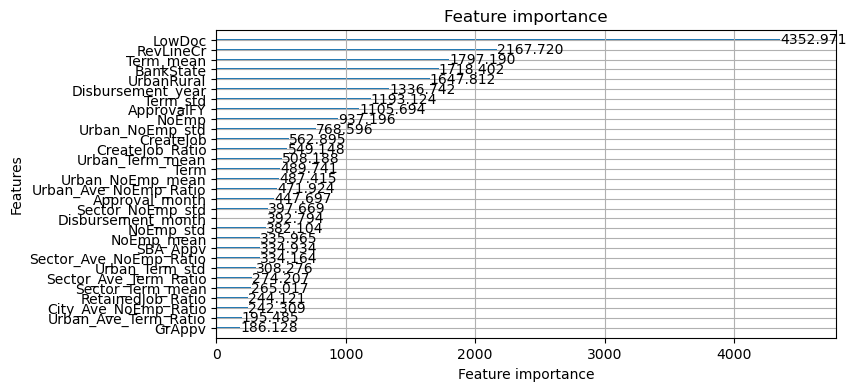

In [128]:
lgb.plot_importance(lgb_model, figsize=(8,4), max_num_features=30, importance_type='gain')

In [129]:
train_df["UrbanRural"].value_counts()

0    24037
1    11759
2     6511
Name: UrbanRural, dtype: int64